In [2]:
import pandas as pd
import numpy as np
import re
import jieba
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer

In [3]:
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [4]:
# # 下载VADER词典
# nltk.download('vader_lexicon')

# 读取TSV文件
file_path = 'input'  # 替换为你的文件路径
#PhraseId	SentenceId	Phrase	Sentiment
train_data = reduce_memory_usage(pd.read_csv(file_path + r'\train.tsv', sep='\t',
                         dtype={'PhraseId': int, 'SentenceId': int, 'Phrase': str, 'Sentiment': int}))
test_data = reduce_memory_usage(pd.read_csv(file_path + r'\test.tsv', sep='\t',
                        dtype={'PhraseId': int, 'SentenceId': int, 'Phrase': str}))

Mem. usage decreased to 2.23 Mb (25.0% reduction)
Mem. usage decreased to 0.89 Mb (12.5% reduction)


In [18]:
#数据检视
print(train_data.info())
train_data.head()
# 无空缺值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int32 
 1   SentenceId  156060 non-null  int32 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int32 
dtypes: int32(3), object(1)
memory usage: 3.0+ MB
None


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


该数据集由制表符分隔的文件组成，其中包含来自 Rotten Tomatoes 数据集的短语。为了基准测试，保留了 train/test 拆分，但句子已从其原始顺序中重新排列。每个句子都已被 Stanford 解析器解析为许多短语。每个短语都有一个 PhraseId。每个句子都有一个 SentenceId。重复的短语（如短/常用词）在数据中仅包含一次。

train.tsv 包含短语及其关联的情绪标签。我们还提供了一个 SentenceId，以便您可以跟踪哪些短语属于单个句子。
test.tsv 仅包含短语。您必须为每个短语分配一个情绪标签。
情绪标签包括：

0 - 负数
1 - 有点负数
2 - 中性
3 - 有点数负数
4 - 数正数

In [20]:
print(test_data.info())
test_data.head()
# Phasre有一个空缺值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PhraseId    66292 non-null  int32 
 1   SentenceId  66292 non-null  int32 
 2   Phrase      66291 non-null  object
dtypes: int32(2), object(1)
memory usage: 1.0+ MB
None


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [5]:
print(train_data["SentenceId"].nunique(), test_data["SentenceId"].nunique())
print(train_data["Sentiment"].value_counts())

8529 3310
Sentiment
2    79582
3    32927
1    27273
4     9206
0     7072
Name: count, dtype: int64


这里可看到测试集有一个空缺值，后面在文本向量化和建模的时候会导致报错。
`ValueError: np.nan is an invalid document, expected byte or unicode string.`  
一开始想用众数填充或其他填充方法，但想到原论文分词的逻辑并不会出现空词，于是特意看了下数据。

In [ ]:
'''Pandas 在读取 csv 文件时时按块读取的，并不会一次性读取，并且对于数据的类型“都靠猜”，所以就可能出现了 Pandas 在不同块对同一列的数据“猜”出了不同的数据类型，也就造成了上述的警告。

而如果关闭 low_memory 功能时，Pandas  就会一次性读取 csv 中德所有数据，自然对列的数据类型也只会猜测一次，就不会造成这种警告了。但是关闭 low_memory 时，一旦 csv 文件过大，就会内存溢出，所以建议采取指定类型的方式。

low_memory : boolean, default True
Internally process the file in chunks, resulting in lower memory use while parsing, but possibly mixed type inference. To ensure no mixed types either set False, or specify the type with the dtype parameter. Note that the entire file is read into a single DataFrame regardless, use the chunksize or iterator parameter to return the data in chunks. (Only valid with C parser)'''

'Pandas 在读取 csv 文件时时按块读取的，并不会一次性读取，并且对于数据的类型“都靠猜”，所以就可能出现了 Pandas 在不同块对同一列的数据“猜”出了不同的数据类型，也就造成了上述的警告。\n\n而如果关闭 low_memory 功能时，Pandas  就会一次性读取 csv 中德所有数据，自然对列的数据类型也只会猜测一次，就不会造成这种警告了。但是关闭 low_memory 时，一旦 csv 文件过大，就会内存溢出，所以建议采取指定类型的方式。\n\nlow_memory : boolean, default True\nInternally process the file in chunks, resulting in lower memory use while parsing, but possibly mixed type inference. To ensure no mixed types either set False, or specify the type with the dtype parameter. Note that the entire file is read into a single DataFrame regardless, use the chunksize or iterator parameter to return the data in chunks. (Only valid with C parser)'

In [6]:
#查看test_data中空缺值位置
vaild_data = test_data[test_data["SentenceId"].isin(test_data[test_data.isnull().any(axis=1)]["SentenceId"])]
vaild_data

,PhraseId,SentenceId,Phrase
15516,171577,9213,None of this violates the letter of Behan 's b...
15517,171578,9213,None of this violates the letter of Behan 's b...
15518,171579,9213,None of this
15519,171580,9213,NaN
15520,171581,9213,"violates the letter of Behan 's book , but mis..."
15521,171582,9213,violates
15522,171583,9213,"the letter of Behan 's book , but missing"
15523,171584,9213,the letter
15524,171585,9213,letter
15525,171586,9213,"of Behan 's book , but missing"


根据分词逻辑，推测test分词时Sentence 9213 Phrase 171580的字面值为"None"，导致读入时误识别为了NoneType。这里将其还原为 "None" 字符串即可。（实际发现读取时指定dtype无法避免这个错误，故特殊处理）

In [7]:
test_data.at[15519, "Phrase"] = "None"
test_data.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
dtype: int64

In [1]:
#fitten code
#词袋模型
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix


In [9]:
# 将短语和标签提取出来
X = train_data['Phrase']  # 短语
y = train_data['Sentiment']  # 情感标签

# 将数据拆分为训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# 文本向量化
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)


In [11]:
print(X_train_vec)
print("词频矩阵：", X_train_vec.toarray())

  (0, 2244)	1
  (1, 14262)	1
  (1, 11383)	1
  (2, 14939)	1
  (2, 8967)	1
  (2, 506)	1
  (2, 13499)	1
  (2, 8052)	1
  (2, 13532)	1
  (2, 1962)	1
  (2, 8855)	1
  (2, 7419)	1
  (2, 5098)	1
  (2, 9377)	1
  (2, 14902)	2
  (2, 6784)	1
  (2, 13550)	1
  (2, 10261)	1
  (2, 8466)	1
  (3, 12431)	1
  (3, 1355)	1
  (3, 12256)	1
  (3, 1430)	1
  (3, 624)	1
  (3, 12484)	1
  :	:
  (124845, 9225)	1
  (124845, 8027)	1
  (124845, 13302)	1
  (124845, 14204)	1
  (124845, 8798)	1
  (124845, 3592)	1
  (124845, 9930)	1
  (124846, 506)	1
  (124846, 9377)	1
  (124846, 624)	1
  (124846, 15173)	1
  (124846, 9324)	1
  (124846, 7228)	1
  (124846, 1893)	1
  (124846, 8027)	1
  (124846, 6649)	1
  (124846, 13515)	1
  (124846, 10026)	1
  (124846, 10731)	1
  (124846, 8375)	1
  (124846, 2228)	1
  (124847, 624)	1
  (124847, 972)	1
  (124847, 4014)	1
  (124847, 4507)	1
词频矩阵： [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [12]:
print(X_val_vec)
print("词频矩阵:", X_val_vec.toarray())

  (0, 855)	1
  (0, 12464)	1
  (1, 137)	1
  (1, 624)	1
  (1, 1208)	1
  (1, 1246)	1
  (1, 1878)	1
  (1, 2585)	1
  (1, 2641)	1
  (1, 3448)	1
  (1, 3926)	1
  (1, 5117)	1
  (1, 6307)	1
  (1, 8339)	1
  (1, 9211)	1
  (1, 9377)	1
  (1, 11326)	1
  (1, 11747)	1
  (1, 13532)	1
  (1, 13675)	1
  (1, 13989)	1
  (2, 3310)	1
  (2, 9225)	1
  (2, 13528)	1
  (3, 5241)	1
  :	:
  (31202, 13675)	2
  (31203, 1799)	1
  (31204, 624)	1
  (31204, 4499)	1
  (31204, 6995)	1
  (31205, 4744)	1
  (31205, 13063)	1
  (31206, 6710)	1
  (31206, 10164)	1
  (31206, 13499)	1
  (31207, 4566)	1
  (31207, 5414)	1
  (31208, 6630)	1
  (31208, 15056)	1
  (31209, 465)	1
  (31209, 2732)	1
  (31209, 6784)	1
  (31209, 13499)	2
  (31209, 13500)	1
  (31210, 2435)	1
  (31210, 3203)	1
  (31210, 10054)	1
  (31211, 2386)	1
  (31211, 13499)	1
  (31211, 14719)	1
词频矩阵: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [15]:
X_train_vec.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [14]:
X_val_vec

<31212x15228 sparse matrix of type '<class 'numpy.int64'>'
	with 194056 stored elements in Compressed Sparse Row format>

Countvectorizer只会对字符长度不小于2的单词进行处理，如果单词就一个字符，这个单词就会被忽略。 注意 ，经过训练后，CountVectorizer就可以对测试集文件进行向量化了，但是向量化出来的特征只是训练集出现的单词特征，如果测试集出现了训练集中没有的单词，就无法在词袋模型中体现了。

In [25]:
# 使用朴素贝叶斯分类器进行训练
model = MultinomialNB()
model.fit(X_train_vec, y_train)


MultinomialNB()

In [ ]:
# 在验证集上进行预测
y_val_pred = model.predict(X_val_vec)


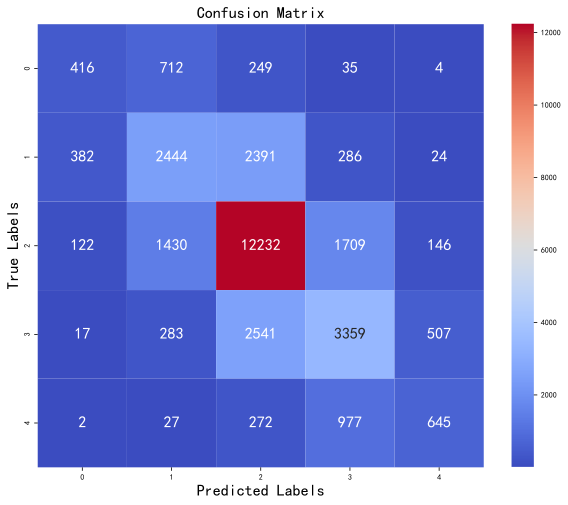

              precision    recall  f1-score   support

           0       0.44      0.29      0.35      1416
           1       0.50      0.44      0.47      5527
           2       0.69      0.78      0.73     15639
           3       0.53      0.50      0.51      6707
           4       0.49      0.34      0.40      1923

    accuracy                           0.61     31212
   macro avg       0.53      0.47      0.49     31212
weighted avg       0.60      0.61      0.60     31212



In [ ]:
# 绘制混淆矩阵
conf_matrix = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels',fontsize=16)
plt.ylabel('True Labels',fontsize=16)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# 输出分类报告
print(classification_report(y_val, y_val_pred))


In [29]:
# 对于测试集进行预测

X_test = test_data['Phrase']

# 文本向量化测试集
X_test_vec = vectorizer.transform(X_test)

# 进行情感预测
y_test_pred = model.predict(X_test_vec)



In [33]:
# 将预测结果保存到文件
submission = pd.DataFrame({'PhraseId': test_data['PhraseId'], 'Sentiment': y_test_pred})
submission.to_csv(r'submission_bagging.csv', index=False)

# # 疑似测试集有空数据导致无法转换为向量，因此需要做一下处理
# # 参考：https://stackoverflow.com/questions/47064518/sklearn-text-vectorization-valueerror-input-contains-nan-infinity-or-a-value-too-larg

scikit-learn库中的tf-idf转换与标准公式稍微不同，而且tf-idf结果会用L1或L2范数进行标准化。

In [34]:
# TF-IDF 文本向量化
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
# TfidfVectorizer 结合了 CountVectorizer 和 TfidfTransformer 的功能
# 可以直接将文本数据转换为 TF-IDF 表示。

In [35]:
vectorizer2 = TfidfVectorizer(stop_words='english')
X_train_vec2 = vectorizer2.fit_transform(X_train)
X_val_vec2 = vectorizer2.transform(X_val)

print(X_train_vec2.toarray())
print(X_val_vec2.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [36]:
# 使用朴素贝叶斯分类器进行训练
model2 = MultinomialNB()
model2.fit(X_train_vec2, y_train)

y_val_pred2 = model2.predict(X_val_vec2)
print(classification_report(y_val, y_val_pred2))


              precision    recall  f1-score   support

           0       0.65      0.05      0.09      1416
           1       0.52      0.28      0.36      5527
           2       0.61      0.89      0.72     15639
           3       0.53      0.40      0.46      6707
           4       0.66      0.06      0.11      1923

    accuracy                           0.59     31212
   macro avg       0.59      0.33      0.35     31212
weighted avg       0.58      0.59      0.53     31212



In [ ]:
# 使用朴素贝叶斯分类器进行训练
model2 = MultinomialNB()
model2.fit(X_train_vec2, y_train)

y_val_pred2 = model2.predict(X_val_vec2)


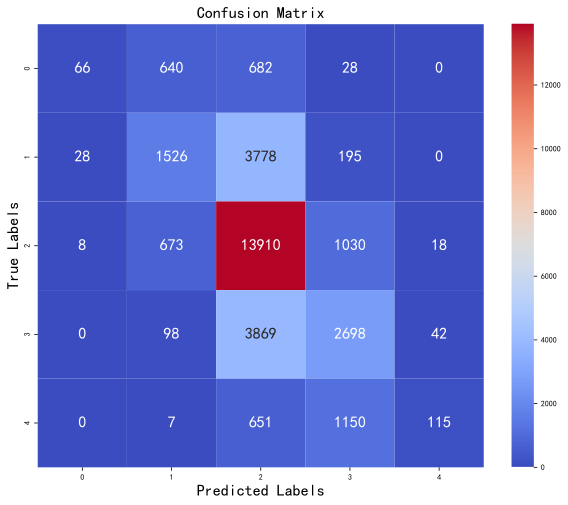

              precision    recall  f1-score   support

           0       0.65      0.05      0.09      1416
           1       0.52      0.28      0.36      5527
           2       0.61      0.89      0.72     15639
           3       0.53      0.40      0.46      6707
           4       0.66      0.06      0.11      1923

    accuracy                           0.59     31212
   macro avg       0.59      0.33      0.35     31212
weighted avg       0.58      0.59      0.53     31212



In [ ]:
# 绘制混淆矩阵
conf_matrix2 = confusion_matrix(y_val, y_val_pred2)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix2, annot=True, annot_kws={"size": 16}, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels',fontsize=16)
plt.ylabel('True Labels',fontsize=16)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# 输出分类报告
print(classification_report(y_val, y_val_pred2))


In [39]:
# 预测测试集
X_test_vec2 = vectorizer2.transform(X_test)
y_test_pred2 = model2.predict(X_test_vec2)

submission2 = pd.DataFrame({'PhraseId': test_data['PhraseId'], 'Sentiment': y_test_pred})
submission2.to_csv(r'submission_tfidf_MutiNB.csv', index=False)

## 文本向量化
我们将使用词袋模型对文本进行向量化。词袋模型将每个句子转换为一个向量，其中向量的每一维对应于一个单词，向量中的元素值表示该单词在句子中出现的次数。

首先，我们需要安装一些必要的包：

```python
!pip install nltk
!pip install gensim
```

```python
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
```

```python
nltk.download('punkt')
```

```python
sentences = [
    "This is a good movie.",
    "This is a bad movie.",
    "I like this movie.",
    "I don't like this movie."
]
```

```python
# Tokenize the sentences
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]

# Train the Word2Vec model
model = Word2Vec(tokenized_sentences, min_count=1)
```

```python
# Get the vector representation of a sentence
vector = model.wv['good']
print(vector)
```

